In [1]:
import os, glob, time
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
# here are the GoodVibes imports! 
import goodvibes.GoodVibes as gv
import goodvibes.thermo as thermo

# The following lines are only necessary if you want to select non-default options
gvibes = gv.GV_options()
gvibes.parse_args()
options, args = gvibes.options, gvibes.args

In [3]:
# directory containing some output files
fdir = 'goodvibes/examples/'

### 01: Grimme-type quasi-harmonic correction with a (Grimme type) cut-off of 150 cm-1

In [4]:
files = ['methylaniline.out', 'benzene.out']

# Change low frequency cutoff from 100 to 150 cm-1 
options.S_freq_cutoff = 150

# Carry out the thermochemical analysis
bbe_vals = [thermo.calc_bbe(fdir+file, sp_file=None) for file in files]

In [5]:
# Create pandas dataframe with thermochemical values
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
df = pd.DataFrame([[getattr(bbe,k) for k in vals] for bbe in bbe_vals], columns = vals)
df.insert(loc=0, column='Structure', value=[name for name in files])
df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,methylaniline.out,-326.664901,0.142118,-326.514489,0.000133,0.000133,-326.554157,-326.554024
1,benzene.out,-232.227201,0.101377,-232.120521,0.000110,0.000110,-232.153263,-232.153265


### 02: Quasi-harmonic thermochemistry with a larger basis set single point energy correction

In [6]:
# Using an internally linked job
file = fdir+'ethane_spc.out'
options.S_freq_cutoff = 100 # reset
options.spc = 'link' # lets consider an internally-linked job where a single point energy follows a frequency calc.

In [7]:
# Carry out the thermochemical analysis - auto-detect the vibrational scaling factor
import goodvibes.io as io
log = io.Logger("Goodvibes")
level_of_theory = gv.filter_output_files([file], log, options.spc)[1]
options.freq_scale_factor, options.mm_freq_scale_factor = gv.get_vib_scale_factor([file], [level_of_theory[0]], log)

# Carry out the thermochemical analysis
bbe_val = thermo.calc_bbe(file, spc=options.spc, freq_scale_factor=options.freq_scale_factor)



o  Found vibrational scaling factor of 0.977 for B3LYP/6-31G(d) level of theory
   Alecu, I. M.; Zheng, J.; Zhao, Y.; Truhlar, D. G. J. Chem. Theory Comput. 2010, 6, 2872-2887.

In [8]:
# Create dataframe with thermochemical values
vals = ['sp_energy', 'scf_energy', 'enthalpy', 'qh_gibbs_free_energy']
df = pd.DataFrame([[getattr(bbe_val,k) for k in vals]], columns = vals)
df.insert(loc=0, column='Structure', value=file)
df

,Structure,sp_energy,scf_energy,enthalpy,qh_gibbs_free_energy
0,goodvibes/examples/ethane_spc.out,-79.858399,-79.830421,-79.780448,-79.808019


In [9]:
# now lets consider the case where the single point energy calculation is in a separate file
file = fdir+'ethane.out'
sp_file = fdir+'ethane_TZ.out'

# Carry out the thermochemical analysis
bbe_val = thermo.calc_bbe(file, sp_file, spc=True, freq_scale_factor=options.freq_scale_factor)

In [10]:
# Create dataframe with thermochemical values
vals = ['sp_energy', 'scf_energy', 'enthalpy', 'qh_gibbs_free_energy']
df = pd.DataFrame([[getattr(bbe_val,k) for k in vals]], columns = vals)
df.insert(loc=0, column='Structure', value=file)
df

,Structure,sp_energy,scf_energy,enthalpy,qh_gibbs_free_energy
0,goodvibes/examples/ethane.out,-79.858399,-79.830421,-79.780448,-79.808019


### 03: Changing the temperature (from standard 298.15 K to 1000 K) and concentration (from standard state in gas phase, 1 atm, to standard state in solution, 1 mol/l)

In [53]:
gvibes = gv.GV_options()
gvibes.parse_args()
options, args = gvibes.options, gvibes.args # reset to default values 

options.conc = 1
options.temperature = 1000
options.freq_scale_factor = 0.95 # for example

In [54]:
# Parse output file for energy, frequency, method, etc.
file = fdir+'methylaniline.out'

# Carry out the thermochemical analysis and then create dataframe with results
bbe_val = thermo.calc_bbe(file, temperature = options.temperature, conc = options.conc, freq_scale_factor = options.freq_scale_factor)
vals = ['scf_energy', 'enthalpy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
df = pd.DataFrame([[getattr(bbe_val,k) for k in vals]], columns = vals)
df.insert(loc=0, column='Structure', value=file)
df

,Structure,scf_energy,enthalpy,gibbs_free_energy,qh_gibbs_free_energy
0,goodvibes/examples/methylaniline.out,-326.664901,-326.457128,-326.680648,-326.678943


### 05: Writing Cartesian coordinates to file

In [57]:
gvibes = gv.GV_options()
gvibes.parse_args()
options, args = gvibes.options, gvibes.args # reset to default values

files = set(glob.glob(fdir+"HCN*.out")) # wildcard for file names
io.write_structures("HCN_output", files, xyz = True)

### 06: Analyzing multiple files at once

In [58]:
gvibes = gv.GV_options()
gvibes.parse_args()
options, args = gvibes.options, gvibes.args # reset to default values 

files = set(glob.glob(fdir+"*.out")) - set(glob.glob(fdir+"*NWChem.out")) # 
files_sorted = sorted (files, key = lambda x: ( isinstance (x, str ), x)) #alphanumeric sorting

In [15]:
# Carry out the thermochemical analysis
# the if statement here filters out structures for which thermochemical data is not available
bbe_vals = [thermo.calc_bbe(file, sp_file=None) for file in files_sorted if hasattr(thermo.calc_bbe(file, sp_file=None), 'zpe')]
names = [file.split(fdir)[1] for file in files_sorted if hasattr(thermo.calc_bbe(file, sp_file=None), 'zpe')]


In [16]:
# Create dataframe with thermochemical values
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=names)
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy
0,Al_298K.out,-242.328708,0.000000,-242.326347,0.000059,0.000059,-242.344018,-242.344018
1,Al_400K.out,-242.328708,0.000000,-242.326347,0.000059,0.000059,-242.344018,-242.344018
2,CuCN.out,-289.005463,0.006594,-288.994307,0.000087,0.000087,-289.020260,-289.020264
3,H2O.out,-76.368128,0.020772,-76.343577,0.000072,0.000072,-76.365035,-76.365035
4,HCN_singlet.out,-93.358851,0.015978,-93.339373,0.000077,0.000077,-93.362269,-93.362269
5,HCN_triplet.out,-93.153787,0.012567,-93.137780,0.000081,0.000081,-93.161850,-93.161850
6,allene.out,-116.569605,0.053913,-116.510916,0.000093,0.000093,-116.538534,-116.538537
7,benzene.out,-232.227201,0.101377,-232.120521,0.000110,0.000110,-232.153263,-232.153265
8,ethane.out,-79.830421,0.075238,-79.750770,0.000092,0.000092,-79.778293,-79.778295
9,ethane_spc.out,-79.830421,0.075238,-79.750770,0.000092,0.000092,-79.778293,-79.778295


In [17]:
# Total CPU time
thermo_data = dict(zip(files_sorted, bbe_vals)) 
cpu = gv.calc_cpu(thermo_data, log)

   TOTAL CPU      0 days  2 hrs 37 mins  0 secs


### 07: Entropic Symmetry Correction

In [18]:
names = ["allene.out", "benzene.out", "ethane.out", "isobutane.out", "neopentane.out"]
files = [fdir+name for name in names]
    
bbe_vals = [thermo.calc_bbe(file, sp_file=None, ssymm=True) for file in files]

In [19]:
# Create dataframe with thermochemical values
vals = ['scf_energy', 'zpe', 'enthalpy', 'entropy', 'qh_entropy', 'gibbs_free_energy', 'qh_gibbs_free_energy', 'point_group']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=names)
bbe_df

,Structure,scf_energy,zpe,enthalpy,entropy,qh_entropy,gibbs_free_energy,qh_gibbs_free_energy,point_group
0,allene.out,-116.569605,0.053913,-116.510916,0.000093,0.000093,-116.538534,-116.538537,D2d
1,benzene.out,-232.227201,0.101377,-232.120521,0.000102,0.000102,-232.150917,-232.150919,D6h
2,ethane.out,-79.830421,0.075238,-79.750770,0.000087,0.000087,-79.776601,-79.776603,D3d
3,isobutane.out,-158.458811,0.132380,-158.319804,0.000111,0.000111,-158.353008,-158.353019,C3v
4,neopentane.out,-197.772980,0.160311,-197.604824,0.000116,0.000116,-197.639430,-197.639444,Td


### 08: Potential Energy Surface (PES) Generation

In [20]:
pesdir = 'goodvibes/examples/reaction_profile/'
files = glob.glob(pesdir+"*.log")
sp_files = glob.glob(pesdir+"*.out")

In [21]:
# thermochemical calculation
bbe_vals = [thermo.calc_bbe(file, sp_file=sp, spc=True) for file,sp in zip(files,sp_files)]

# Show a table
vals = ['sp_energy', 'scf_energy', 'zpe', 'enthalpy', 'qh_gibbs_free_energy']
bbe_df = pd.DataFrame([[getattr(i,k) for k in vals] for i in bbe_vals], columns = vals)
bbe_df.insert(loc=0, column='Structure', value=[file.split(pesdir)[1] for file in files])
bbe_df.head()

,Structure,sp_energy,scf_energy,zpe,enthalpy,qh_gibbs_free_energy
0,Int_I_Py_d.log,-1415.698106,-1415.698106,0.418680,-1415.254939,-1415.328850
1,Int_I_Py_e.log,-1415.697383,-1415.697383,0.418818,-1415.254065,-1415.328111
2,Int_I_Py_f.log,-1415.706212,-1415.706212,0.419258,-1415.262679,-1415.335952
3,Int_I_Py_b.log,-1415.711031,-1415.711031,0.419045,-1415.267713,-1415.340929
4,Int_I_Py_c.log,-1415.713255,-1415.713255,0.418916,-1415.269974,-1415.343483


In [22]:
# Convert absolute values into a relatve PES 
options.pes = pesdir+'PhPy.yaml' # external file defining PES
options.gconf = False

import goodvibes.pes as pes
thermo_data = dict(zip(files, bbe_vals))
species, table = pes.tabulate(thermo_data, options, log, show=True)


   RXN: Ph (kcal/mol)                             DE_SPC            DE       DZPE        DH_SPC       T.DS    T.qh-DS      DG(T)_SPC   qh-DG(T)_SPC
   *******************************************************************************************************************************************************
o  Ph-Int1                                          0.00          0.00       0.00          0.00       0.00       0.00          0.00          0.00
o  Ph-TS1                                          23.93         23.93      -1.60         22.34       0.68       0.50         22.14         22.19
o  Ph-Int2                                        -14.22        -14.22      -0.57        -14.54       3.69       2.02        -15.64        -15.14
o  Ph-TS2                                         -12.25        -12.25      -1.35        -13.55       2.75       1.13        -14.37        -13.89
o  Ph-Int3                                        -37.69        -37.69      -0.57        -37.68       9.78      


   Graphing Reaction Profile


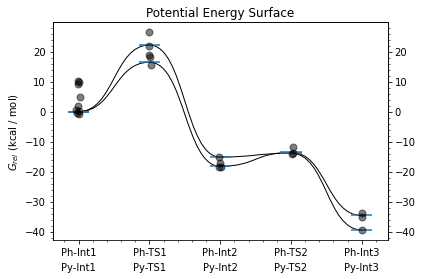

In [23]:
# Plot the PES
import matplotlib.pyplot as plt
graph_data = pes.get_pes(options.pes, thermo_data, log, options.temperature, options.gconf)
pes.graph_reaction_profile(graph_data, options, log, plt)

### 09: Stereoselectivity and Boltzmann populations

In [59]:
gvibes = gv.GV_options()
gvibes.parse_args()
options, args = gvibes.options, gvibes.args # reset to default values 

seldir = 'goodvibes/examples/reaction_selectivity/opt/'
files = glob.glob(seldir+"*.log")
files = sorted (files, key = lambda x: ( isinstance (x, str ), x)) #alphanumeric sorting

spcdir = 'goodvibes/examples/reaction_selectivity/spc_01/'
sp_files = glob.glob(spcdir+"*.log")
sp_files = sorted (sp_files, key = lambda x: ( isinstance (x, str ), x)) #alphanumeric sorting

options.dedup = True
options.Boltz = True
# Define two groups of files by wildcard matching
options.ee = "*_13_*:*_14_*"

In [61]:
bbe_vals = [thermo.calc_bbe(file, sp_file=sp, spc=True) for file,sp in zip(files,sp_files)]
thermo_data = dict(zip(files, bbe_vals))
thermo_data = gv.sort_by_stability(thermo_data, options.sort)

# obtain Boltzmann factors
boltz_facs, weighted_free_energy = gv.get_boltz(thermo_data, options.clustering, [], options.temperature, log)

#and selectivity values
[a_name, b_name], [a_files, b_files], ee, er, ratio, dd_free_energy, preference = gv.get_selectivity(options.ee, files, boltz_facs, options.temperature, log)


   Selectivity                                Excess (%)     Ratio (%)         Ratio         Major  DDG kcal/mol
   *************************************************************************************************************
o                                                  99.21         0:100         1:252            14          3.28
   *************************************************************************************************************


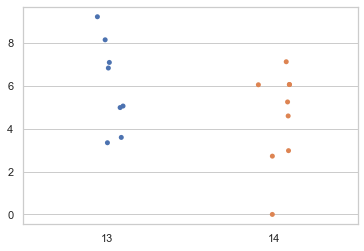

In [63]:
#plot the relative Gibbs energies
pes.sel_striplot(a_name, b_name, a_files, b_files, thermo_data, plt)